**Reinforcement Learning with TensorFlow & TRFL: Policy Gradient Loss**

Outline:
1. Introduce Lunar Lander
* Policy Gradient methods with REINFORCE
* Discrete vs. Continuous Action Spaces
* Discrete Policy Gradient with TRFL
* Continuous Policy Gradient with TRFL
* TRFL Policy Gradient Loss Functions




In [0]:
#TRFL works with TensorFlow 1.12
#installs TensorFlow version 1.12 then restarts the runtime
!pip install tensorflow==1.12

import os
os.kill(os.getpid(), 9)

In [0]:
#install tensorflow-probability 0.5.0 that works with TensorFlow 1.12
!pip install tensorflow-probability==0.5.0

#install TRFL
!pip install trfl

#install box2d for LunarLanding env
!pip install box2d-py


In [0]:
#tools for visualizing environment
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1

from IPython import display as ipythondisplay
from pyvirtualdisplay import Display

In [0]:
import gym
import tensorflow as tf
import trfl
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_probability as tfp


** LunarLander **

LunarLander is an OpenAI gym environment (env). In this env the agent tries to land a space craft safely on the ground by firing the main, left, or right engine. The agent receives a reward for navigating to the landing pad and turning off the engine, a large reward for a safe landing, a large negative reward for an unsafe landing, and a small negative reward for using the engines. Solved is a score of 200. There are discrete (four actions) and continuous (2 actions) versions of LunarLanding


<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '400x300x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '400x300x24', ':1001'] oserror=None return_code=0 stdout="" stderr="" timeout_happened=False>

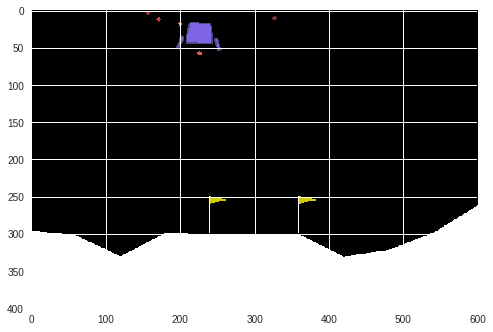

In [0]:
#visualization of environment 
#code from here: https://colab.research.google.com/drive/16gZuQlwxmxR5ZWYLZvBeq3bTdFfb1r_6#scrollTo=6L4YayzR4FYj&forceEdit=true&offline=true&sandboxMode=true

display = Display(visible=0, size=(400, 300))
display.start()
env = gym.make('LunarLander-v2')
env.reset()
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

for i in range(50):
  action = env.action_space.sample()
  obs, reward, done, info = env.step(action)
  screen = env.render(mode='rgb_array')
  
  plt.imshow(screen)
  ipythondisplay.clear_output(wait=True)
  ipythondisplay.display(plt.gcf())

  if done:
    break
    
ipythondisplay.clear_output(wait=True)
env.close()
display.stop()

** Policy Gradient Methods **

In policy gradient methods, we update the policy directly. Ie we parameterize the policy and perform gradient descent updates on the policy parameters seeking to improve the policy. This is in contrast to sections 1 and 2 where we learned estimates of the state or action-values. Then we extracted a policy based on those values, like with the epsilon greedy policy. 

** Discrete vs. Continuous Action Spaces **

PG methods can work in discrete and continuous action spaces. The DQN method we went over in section 2 required discrete action spaces: ie a limited number of actions. In continuous actions spaces there are an infinite number of actions as the action can be any value in a range. Continuous action spaces are often parameterized by a probability distribution and we learn the parameters of the distribution. For example we assume the actions come from a Gaussian distribution and try to learn the mean and standard deviation of the Gaussian that leads to the best policy. TRFL has functions for both discrete and continuous policy gradients.


** Example 1: Discrete Policy Gradient with Lunar Lander **

In the first example, we will solve the discrete version of Lunar Lander using policy gradient methods, in particular the REINFORCE algorithm.



In [0]:
# set up policy network

class PolicyNetwork:
  def __init__(self, name, learning_rate=0.001, obs_size=2, action_size=3, hidden_size=64):
    
    with tf.variable_scope(name):
      self.name=name
      # set up placeholders
      self.input_ = tf.placeholder(tf.float32, [None, obs_size], name='inputs')
      self.action_ = tf.placeholder(tf.int32, [None], name='action')
      self.value_ = tf.placeholder(tf.float32, [None], name='values')
      
      # set up policy network
      self.fc1_ = tf.contrib.layers.fully_connected(self.input_, hidden_size, activation_fn=tf.nn.relu)
      self.fc2_ = tf.contrib.layers.fully_connected(self.fc1_, hidden_size, activation_fn=tf.nn.relu)
      self.fc3_ = tf.contrib.layers.fully_connected(self.fc2_, action_size, activation_fn=None)

      # generate action probabilities for taking actions
      self.action_prob_ = tf.nn.softmax(self.fc3_)
      
      # TRFL usage
      self.pg_loss_ = trfl.discrete_policy_gradient(self.fc3_, self.action_, self.value_) 
      
      # Optimize the loss
      self.loss_ = tf.reduce_mean(self.pg_loss_)
      self.optim_ = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.loss_)
      

** TRFL Usage **

TRFL usage follows the three basic steps. We set up the tensor and the policy network in the graph. We input the output of policy network and placeholders for actions and values into trfl.discrete_policy_gradients. In REINFORCE the values placeholder is from the trajectory of rewards. In the session we run the optimizer to train on the policy gradient loss.

To get the action probabilities we set up self.action_prob_ and take the softmax of the output of the policy network. Then in the session we'll run self.action_prob_ and sample from that probability to select an action.



In [0]:
# hyperparameters
train_episodes = 5000                     
discount = 0.99     

hidden_size = 32
learning_rate = 0.002

seed = 31
env = gym.make('LunarLander-v2')
env.seed(seed)
np.random.seed(seed)

action_size = env.action_space.n
obs_size = env.observation_space.shape[0]

tf.reset_default_graph()
tf.set_random_seed(seed)
# Create policy network
policy_net = PolicyNetwork(name='policy_net', hidden_size=hidden_size, obs_size=obs_size,
                          action_size=action_size, learning_rate=learning_rate)

In [0]:
# TRFL Usage: scan_discounted_sum
seq_ = tf.placeholder(dtype=tf.float32)
disc_seq_ = tf.placeholder(dtype=tf.float32)
init_value_ = tf.placeholder(dtype=tf.float32)
scan_disc_sum_ = trfl.scan_discounted_sum(seq_, disc_seq_, init_value_,reverse=True)

** TRFL Usage **

Scan discounted sum is a convenient function for handling sequences of rewards and discounts. We set up the placeholders for the sequence of rewards, the sequence of discounts, and the initial value of the sequence. Then in the session we feed the reward and discount trajectories and initial values into the feed dictionary for the TRFL tensor.

In [0]:
stats_rewards_list = []

with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    for ep in range(1, train_episodes):
        total_reward = 0
        ep_length = 0
        state = env.reset() 
        state = np.clip(state,-1.5,1.5) #clip state within useful range of values
        done = 0
        
        # store trajectories in lists, when episode is done use trajectories to train agents
        obs_list, rew_list, action_list = [], [], []
        
        # stop episodes when agent is able to solve game
        if len(stats_rewards_list) > 10 and np.mean(stats_rewards_list[-10:],axis=0)[1] > 200:
          print("Stopping at episode {} with average rewards of {} in last 10 episodes".
                format(ep,np.mean(stats_rewards_list[-10:],axis=0)[1]))
          break
          
        while not done:
            # generate action probabilities from policy net and sample from the action probs
            action_probs = sess.run(policy_net.action_prob_, feed_dict={policy_net.input_: np.expand_dims(state,axis=0)})
            action_probs = action_probs[0]
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)

            obs_list.append(state)
            action_list.append(action)
            
            state, reward, done, info = env.step(action)
            state = np.clip(state,-1.5,1.5)
            total_reward += reward
            
            # scale rewards
            reward *= .01
            rew_list.append(reward)
            
            
            ep_length += 1
            
            if total_reward < -250:
              done = 1
              
            if done:
              # get reward values placeholder to multipy log probs
              # collect rewards until episode is over, then discount over trajectory by using trfl.scan_discounted_sum
              discount_array = np.array([discount]*len(rew_list))
              values = sess.run(scan_disc_sum_, feed_dict={seq_:np.array(rew_list, dtype=np.float32), 
                                                            disc_seq_:discount_array, init_value_:np.array([0.])})
              
              # clip reward trajectory
              scaled_values = np.clip(values,-10.,10.0)
              
              # train policy on collected trajectories
              _, stats_loss = sess.run([policy_net.optim_, policy_net.loss_], 
                                       feed_dict={ policy_net.input_: np.array(obs_list),
                                                 policy_net.action_: np.array(action_list,dtype=np.int32),
                                                 policy_net.value_: np.squeeze(scaled_values)} )
              
              if ep % 10 == 0:
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Ep length: {}'.format(ep_length),
                      'Training loss: {:.4f}'.format(stats_loss))
              stats_rewards_list.append((ep, total_reward))
                
              break
         

Episode: 10 Total reward: -330.54493048497784 Ep length: 75 Training loss: -2.4181
Episode: 20 Total reward: -279.6854432589248 Ep length: 126 Training loss: -1.8925
Episode: 30 Total reward: -252.89484691641738 Ep length: 91 Training loss: -1.5892
Episode: 40 Total reward: -255.9141187083156 Ep length: 84 Training loss: -1.4671
Episode: 50 Total reward: -106.58363789771707 Ep length: 74 Training loss: -0.9882
Episode: 60 Total reward: -101.88871365620335 Ep length: 103 Training loss: -0.6531
Episode: 70 Total reward: -134.48033127150035 Ep length: 98 Training loss: -1.0508
Episode: 80 Total reward: -117.41169292171375 Ep length: 111 Training loss: -0.9361
Episode: 90 Total reward: -118.40005852678563 Ep length: 100 Training loss: -0.8493
Episode: 100 Total reward: -143.96006656750757 Ep length: 96 Training loss: -1.0812
Episode: 110 Total reward: -77.9776855717478 Ep length: 65 Training loss: -0.6821
Episode: 120 Total reward: -111.95766907369561 Ep length: 82 Training loss: -1.0307
E

Text(0, 0.5, 'Total Reward')

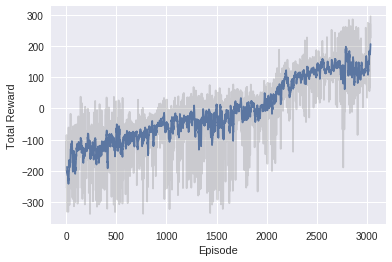

In [0]:
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N
eps, rews = np.array(stats_rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

** Example 2: Continuous Policy Gradient **

In this example we solve continuous Lunar Lander.

In [0]:
# set up policy network

class PolicyNetwork:
  def __init__(self, name, learning_rate=0.001, obs_size=2, action_size=3, hidden_size=64,action_low=-1.,action_high=1.,
              entropy_coefficient=0.005):
    
    with tf.variable_scope(name):
      self.input_ = tf.placeholder(tf.float32, [None, obs_size], name='inputs')
      self.action_ = tf.placeholder(tf.float32, [None,action_size], name='action')
      self.value_ = tf.placeholder(tf.float32, [None,], name='values') #LL
      self.name=name
      
      # set up loc network
      self.fc1_mu_ = tf.contrib.layers.fully_connected(self.input_, hidden_size, activation_fn=tf.nn.elu)
      self.fc2_mu_ = tf.contrib.layers.fully_connected(self.fc1_mu_, hidden_size, activation_fn=tf.nn.elu)
      self.fc3_mu_ = tf.contrib.layers.fully_connected(self.fc2_mu_, action_size, activation_fn=tf.nn.tanh)
      
      # set up scale network
      self.fc1_scale_ = tf.contrib.layers.fully_connected(self.input_, hidden_size, activation_fn=tf.nn.elu)
      self.fc2_scale_ = tf.contrib.layers.fully_connected(self.fc1_scale_, hidden_size, activation_fn=tf.nn.elu)
      self.fc3_scale_ = tf.contrib.layers.fully_connected(self.fc2_scale_, action_size, activation_fn=tf.nn.sigmoid)
      self.scale_ = self.fc3_scale_*.25 + 1e-5 #must be > 0 hence the small constant and tf.nn.sigmoid
      
      # policy distribution that we parameterize in the continuous case
      self.distribution_ = tfp.distributions.MultivariateNormalDiag(loc=self.fc3_mu_, scale_diag=self.scale_)

      # generate actions by sampling from distributions and clipping them
      self.actions_scaled_ = tf.clip_by_value(self.distribution_.sample(), action_low, action_high) 
      
      # TRFL usage
      self.pg_loss_ = trfl.policy_gradient(self.distribution_, self.action_, self.value_)
      # Get the entropy loss and add it to the pg loss
      self.entropy_loss_, _ = trfl.policy_entropy_loss(self.distribution_)
      self.combined_loss_ = self.pg_loss_ + entropy_coefficient * self.entropy_loss_
      
      # optimizing the loss
      self.loss_ = tf.reduce_mean(self.combined_loss_)
      self.optim_ = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.loss_)
      
      
# Value Function Network to produce baseline estimate. Reduces variance from prior REINFORCE method.
class ValueNetwork:
  def __init__(self, name, learning_rate=0.001, obs_size=2, hidden_size=64):
    
    with tf.variable_scope(name):
      self.name=name
      self.input_ = tf.placeholder(tf.float32, [None, obs_size], name='inputs')
      self.target_ = tf.placeholder(tf.float32, [None,1], name='targets')
      
      #set up value network
      self.fc1_ = tf.contrib.layers.fully_connected(self.input_, hidden_size, activation_fn=tf.nn.elu)
      self.fc2_ = tf.contrib.layers.fully_connected(self.fc1_, hidden_size, activation_fn=tf.nn.elu)
      self.fc3_ = tf.contrib.layers.fully_connected(self.fc2_, 1, activation_fn=None)
      
      # optimizing the loss
      self.loss_ = tf.losses.mean_squared_error(self.fc3_, self.target_)
      self.optim_ = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.loss_)

** TRFL Usage **

Usage for continuous action spaces for trfl.policy_gradient is similar to the discrete case. The main difference is the first argument is a policy distribution in the continuous case. We parameterize the policy distribution with two neural networks whose outputs become inputs for the policy distribution. Note how the tensor placeholder for actions is now a float in this case as the actions are continuous.



In [0]:
# hyperparameters
train_episodes = 10000                     
discount = 0.99   

hidden_size = 64
policy_learning_rate = 0.002
value_learning_rate = 0.02
entropy_coefficient = 0.005
seed = 31
env = gym.make('LunarLanderContinuous-v2')

env.seed(seed)
np.random.seed(seed)
action_size = env.action_space.shape[0]
obs_size = env.observation_space.shape[0]

tf.reset_default_graph()
tf.set_random_seed(seed)
policy_net = PolicyNetwork(name='policy_net', hidden_size=hidden_size, obs_size=obs_size,
                          action_size=action_size, learning_rate=policy_learning_rate, action_low=env.action_space.low[0],
                          action_high=env.action_space.high[0], entropy_coefficient=entropy_coefficient)
value_net = ValueNetwork(name='value_net', hidden_size=hidden_size, obs_size=obs_size, learning_rate=value_learning_rate)


In [0]:
#scan_discounted_sum
seq_ = tf.placeholder(dtype=tf.float32)
disc_seq_ = tf.placeholder(dtype=tf.float32)
init_value_ = tf.placeholder(dtype=tf.float32)
scan_disc_sum_ = trfl.scan_discounted_sum(seq_, disc_seq_, init_value_,reverse=True)

In [0]:
stats_rewards_list = []

with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    for ep in range(1, train_episodes):
        total_reward = 0
        ep_length = 0
        state = np.clip(env.reset(),-1.,1.) 
        done = 0
        obs_list, rew_list, action_list = [],[],[]

        # stop early when env is solved
        if len(stats_rewards_list) > 10 and np.mean(stats_rewards_list[-10:],axis=0)[1] > 200:
          print("Stopping at episode {} with average rewards of {} in last 10 episodes".
                format(ep,np.mean(stats_rewards_list[-10:],axis=0)[1]))
          break
          
        while not done:
            action = sess.run(policy_net.actions_scaled_,feed_dict={policy_net.input_: np.expand_dims(state,axis=0)})
            action = action[0]  

            obs_list.append(state)
            action_list.append(action)
    
            state, reward, done, info = env.step(action)
            total_reward += reward
            reward *= .1
            state = np.clip(state,-1., 1.)
            rew_list.append(reward)
            
            total_reward += reward
            ep_length += 1
              
            if total_reward < -250:
              done = 1

            if done:
              # get reward values placeholder to multipy log probs by using trfl.scan_discounted_sum
              discount_array = np.array([discount]*len(rew_list))
              values = sess.run(scan_disc_sum_,feed_dict={seq_:np.array(rew_list, dtype=np.float32), 
                                                            disc_seq_:discount_array, init_value_:np.array([0.])})
              
              # run value network to get baseline predictions
              baselines = sess.run(value_net.fc3_, feed_dict={
                  value_net.input_:np.array(obs_list),
              })
              
              # advantage of returns over baselines
              advantage = values - baselines
              
              # train value network with reward trajectories
              value_loss, _ = sess.run([value_net.loss_, value_net.optim_], feed_dict={
                  value_net.input_:np.array(obs_list),
                  value_net.target_:values
              })

              # train policy on collected trajectories, use advantage to reduce variance
              _, stats_loss = sess.run([policy_net.optim_, policy_net.loss_], 
                                     feed_dict={ policy_net.input_: np.array(obs_list),
                                               policy_net.action_: np.array(action_list),
                                               policy_net.value_: np.squeeze(advantage)})
              
              if ep % 10 == 0:
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Ep length: {}'.format(ep_length),
                      'Training loss: {:.4f}'.format(stats_loss),
                      'Action means: {}'.format(np.mean(np.array(action_list),axis=0) ))
              stats_rewards_list.append((ep, total_reward))
              break

Episode: 10 Total reward: -253.57308408551594 Ep length: 88 Training loss: -4.7914 Action means: [ 0.48694763 -0.10304736]
Episode: 20 Total reward: -251.8200551280284 Ep length: 107 Training loss: 11.8108 Action means: [ 0.9142881  -0.03049557]
Episode: 30 Total reward: -251.26068756979927 Ep length: 45 Training loss: -0.7603 Action means: [0.94197667 0.1452094 ]
Episode: 40 Total reward: -251.43410142448195 Ep length: 84 Training loss: -3.0194 Action means: [0.9297914  0.03556389]
Episode: 50 Total reward: -235.9122301489981 Ep length: 166 Training loss: -4.5805 Action means: [0.0685885  0.02576823]
Episode: 60 Total reward: -185.53728512216398 Ep length: 59 Training loss: 0.3241 Action means: [-0.4741146  -0.02130498]
Episode: 70 Total reward: -189.08466749012482 Ep length: 100 Training loss: 2.7989 Action means: [-0.33834878  0.11976853]
Episode: 80 Total reward: -265.55622235727446 Ep length: 176 Training loss: -1.3079 Action means: [0.03007684 0.01431746]
Episode: 90 Total reward

Text(0, 0.5, 'Total Reward')

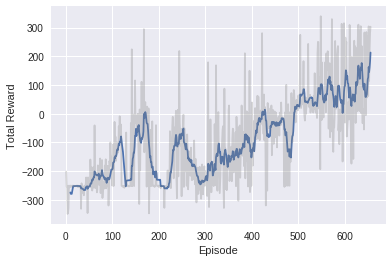

In [0]:
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N
eps, rews = np.array(stats_rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

** Discrete & Continuous Policy Gradient Loss **

TRFL also has functions trfl.discrete_policy_gradient_loss() and trfl.policy_gradient_loss(). These two functions wrap discrete_policy_gradient() and policy_gradient() to allow a nested array of tensors containing policies and actions and allow for multiple actions. We'll see example usage of the these two functions when we implement Actor-Critic networks in TRFL.